In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from nltk.util import ngrams
from pymorphy2 import MorphAnalyzer
from collections import Counter
import pickle
import itertools


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import my_confusion_matrix as mcm

In [2]:
f = open(r'combine_df.txt', 'rb')
train_df = pickle.load(f)
f.close()
train_df.head()

,id,label,tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...",father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...",thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]",bihday majesti,bihday majesty
3,4,0.0,model love yoyou take with yoyou all the time ...,"[model, love, yoyou, take, with, yoyou, all, t...","[model, love, yoyou, take, yoyou, time, yoyour]",model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0.0,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]",factsguid societi motiv,factsguide society motivation


Уберу лишнее

In [3]:
train_df.drop(columns = ['tweet', 'tweet_token', 'tweet_token_filtered'], axis = 1, inplace=True)
train_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
0,1,0.0,father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday majesti,bihday majesty
3,4,0.0,model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0.0,factsguid societi motiv,factsguide society motivation


In [4]:
train_df.isna().sum()

id                      0
label               17197
tweet_stemmed           0
tweet_lemmatized        0
dtype: int64

#### Разделю на train и test

In [5]:
test_df = train_df[train_df['label'].isnull()] #   train_df[train_df.isnull().any(axis=1)]
test_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
31962,31963,NaN,studiolif aislif requir passion dedic willpow ...,studiolife aislife requires passion dedication...
31963,31964,NaN,white supremacist want everyon see new bird movi,white supremacist want everyone see new bird m...
31964,31965,NaN,safe way heal acn altwaystoh healthi heal,safe way heal acne altwaystoheal healthy healing
31965,31966,NaN,hp curs child book reserv alreadi ye harrypott...,hp cursed child book reservation already yes h...
31966,31967,NaN,rd bihday amaz hilari nephew eli ahmir uncl da...,rd bihday amazing hilarious nephew eli ahmir u...


In [6]:
train_df = train_df.loc[~train_df['label'].isnull()]
train_df['label'] = train_df['label'].astype(int)
train_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
0,1,0,father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0,thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0,bihday majesti,bihday majesty
3,4,0,model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0,factsguid societi motiv,factsguide society motivation


In [7]:
train_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

- Классы сильно не сбалансированны, поэтому на данном этапе в метрике буду ориентироваться на кривые Precision-Recall и так как важен вопрос выявления первого класса, в качестве метрики буду использовать F2-score

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(train_df['tweet_stemmed'], train_df['label'], test_size=0.33, random_state=42)

#### Сначала обучу классификаторы на униграммах with default settings

In [9]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(train_x) # bag of words

In [10]:
list(vec.vocabulary_.items())[:10]

[('bbc', 1736),
 ('news', 14994),
 ('russia', 18604),
 ('lake', 12004),
 ('syamozero', 21100),
 ('children', 3847),
 ('die', 5621),
 ('storm', 20618),
 ('catch', 3520),
 ('boat', 2549)]

In [11]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)   # learning on a bag of words
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

In [12]:
precision_CV, recall_CV, thresholds_CV = precision_recall_curve(valid_y, pred)
fscore = (5 * precision_CV * recall_CV) / (4 * precision_CV + recall_CV)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision_CV[ix]:.3f}, Recall={recall_CV[ix]:.3f}')
print(f'Best Threshold={thresholds_CV[ix]:.3f}, F2-Score={fscore[ix]:.3f}, \
 Precision={precision_CV[ix]:.3f}, Recall={recall_CV[ix]:.3f}')

Precision=0.475, Recall=0.787
Best Threshold=0.098, F2-Score=0.696,  Precision=0.475, Recall=0.787


Confusion matrix, without normalization
[[9160  646]
 [ 159  583]]


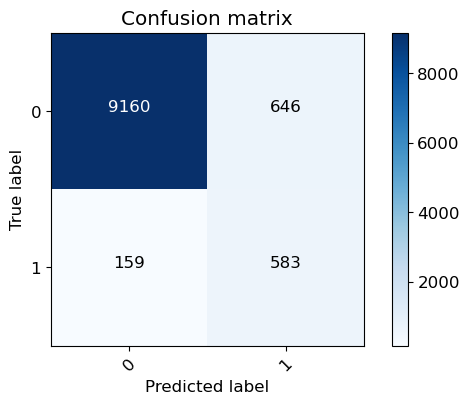

In [13]:
font = {'size' : 12}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(valid_y, pred > thresholds_CV[ix])
plt.figure(figsize=(6, 4))
mcm.plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

- Попробуем сделать то же самое для биграмм:

In [14]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

precision, recall, thresholds = precision_recall_curve(valid_y, pred)
fscore = (5 * precision * recall) / (4 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F2-Score={fscore[ix]:.3f}, \
 Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.506, Recall=0.492
Best Threshold=0.0532220334276551, F2-Score=0.495,  Precision=0.506, Recall=0.492


#### Cделаю расчет применяя TfidfVectorizer 

In [15]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

In [16]:
precision_TV, recall_TV, thresholds_TV = precision_recall_curve(valid_y, pred)
fscore = (5 * precision_TV * recall_TV) / (4 * precision_TV + recall_TV)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision_TV[ix]:.3f}, Recall={recall_TV[ix]:.3f}')
print(f'Best Threshold={thresholds_TV[ix]:.3f}, F2-Score={fscore[ix]:.3f},\
 Precision={precision_TV[ix]:.3f}, Recall={recall_TV[ix]:.3f}')

Precision=0.440, Recall=0.833
Best Threshold=0.098, F2-Score=0.706, Precision=0.440, Recall=0.833


Confusion matrix, without normalization
[[9018  788]
 [ 125  617]]


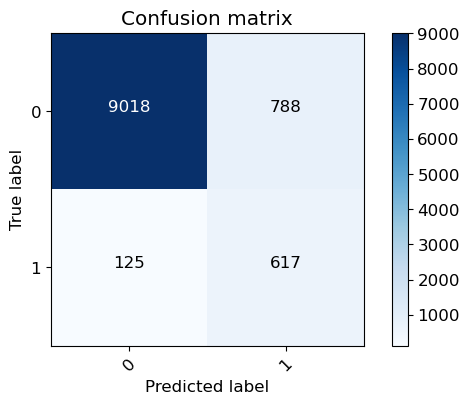

In [17]:
font = {'size' : 12}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(valid_y, pred > thresholds_TV[ix])
plt.figure(figsize=(6, 4))
mcm.plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
features_names = vec.get_feature_names()
temp_df = pd.DataFrame(bow.toarray(), columns=features_names)
temp_df.head()

,aaa,aaaaa,aaaaand,aaahhhh,aaahhhhh,aaand,aaaree,aaareeeejuven,aaareeeelax,aaareeeewind,...,zulu,zuma,zumba,zurich,zx,zydeco,zz,zzz,zzzzzz,zzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Сделаю то же самое для биграмм:

In [19]:
vec = TfidfVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

In [20]:
precision, recall, thresholds = precision_recall_curve(valid_y, pred)
fscore = (5 * precision * recall) / (4 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F2-Score={fscore[ix]:.3f}, \
 Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.516, Recall=0.489
Best Threshold=0.07485412539394204, F2-Score=0.494,  Precision=0.516, Recall=0.489


- И в случае CountVectorizer и TfidfVectorizer биграммы не дают лучшего результата в сравнении с униграммами.

#### Cделаю расчет применяя HashingVectorizer 

Опытным путем определяю параметр n_features

In [21]:
vec = HashingVectorizer(n_features=13500)
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

In [22]:
precision_HV, recall_HV, thresholds_HV = precision_recall_curve(valid_y, pred)
fscore = (5 * precision_HV * recall_HV) / (4 * precision_HV + recall_HV)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision_HV[ix]:.3f}, Recall={recall_HV[ix]:.3f}')
print(f'Best Threshold={thresholds_HV[ix]:.3f}, F2-Score={fscore[ix]:.3f},\
 Precision={precision_HV[ix]:.3f}, Recall={recall_HV[ix]:.3f}')

Precision=0.384, Recall=0.827
Best Threshold=0.095, F2-Score=0.673, Precision=0.384, Recall=0.827


Confusion matrix, without normalization
[[8823  983]
 [ 129  613]]


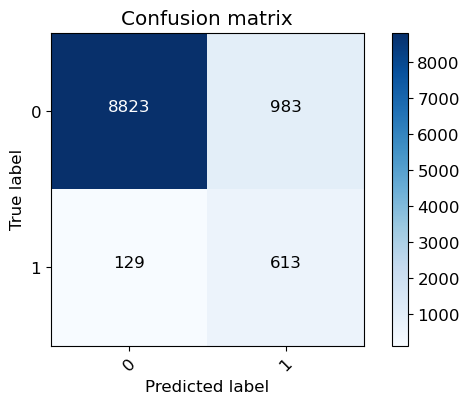

In [23]:
font = {'size' : 12}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(valid_y, pred > thresholds_HV[ix])
plt.figure(figsize=(6, 4))
mcm.plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

- Выведем результаты на график

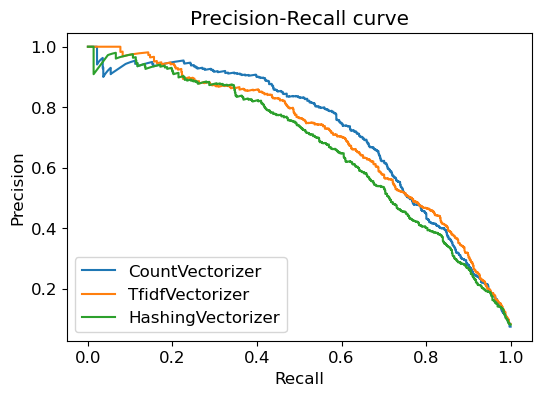

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(recall_CV, precision_CV, label='CountVectorizer')
plt.plot(recall_TV, precision_TV, label='TfidfVectorizer')
plt.plot(recall_HV, precision_HV, label='HashingVectorizer')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

---

#### Делаю вывод

- Если важна полнота (Recall) в определении первого класса, то на этом участке кривой с небольшим преимуществом лидирует TfidfVectorizer. 

- В целом все три векторайзера показали +- одинаковый результат

---

### Так как в предыдущем разделе лидирует TfidfVectorizer, рассмотрим его применяя дополнительные параметры.

- Отсечем из мешка слов высокочастотные токены и посмотрим на показатели метрики.

In [25]:
vec = TfidfVectorizer(ngram_range=(1, 1), max_df=0.00005)
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

In [26]:
precision_TV, recall_TV, thresholds_TV = precision_recall_curve(valid_y, pred)
fscore = (5 * precision_TV * recall_TV) / (4 * precision_TV + recall_TV)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision_TV[ix]:.3f}, Recall={recall_TV[ix]:.3f}')
print(f'Best Threshold={thresholds_TV[ix]:.3f}, F2-Score={fscore[ix]:.3f},\
 Precision={precision_TV[ix]:.3f}, Recall={recall_TV[ix]:.3f}')

Precision=0.079, Recall=0.896
Best Threshold=0.068, F2-Score=0.292, Precision=0.079, Recall=0.896


- Перебирая значение параметра max_df, получим следующие результаты

max_df=0.1
Precision=0.440, Recall=0.833
Best Threshold=0.098, F2-Score=0.706, Precision=0.440, Recall=0.833

max_df=0.09
Precision=0.434, Recall=0.832
Best Threshold=0.096, F2-Score=0.703, Precision=0.434, Recall=0.832

max_df=0.05
Precision=0.443, Recall=0.817
Best Threshold=0.098, F2-Score=0.699, Precision=0.443, Recall=0.817

max_df=0.01
Precision=0.496, Recall=0.747
Best Threshold=0.107, F2-Score=0.678, Precision=0.496, Recall=0.747

max_df=0.005
Precision=0.424, Recall=0.760
Best Threshold=0.087, F2-Score=0.656, Precision=0.424, Recall=0.760

max_df=0.001
Precision=0.394, Recall=0.667
Best Threshold=0.085, F2-Score=0.586, Precision=0.394, Recall=0.667

max_df=0.0005
Precision=0.351, Recall=0.538
Best Threshold=0.084, F2-Score=0.486, Precision=0.351, Recall=0.538

max_df=0.0001
Precision=0.426, Recall=0.294
Best Threshold=0.079, F2-Score=0.313, Precision=0.426, Recall=0.294

max_df=0.00005
Precision=0.079, Recall=0.896
Best Threshold=0.068, F2-Score=0.292, Precision=0.079, Recall=0.896

- Отсечем из мешка слов низкочастотные токены и посмотрим на показатели метрики.

In [27]:
vec = TfidfVectorizer(ngram_range=(1, 1), min_df=0.05)
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict

In [28]:
precision_TV, recall_TV, thresholds_TV = precision_recall_curve(valid_y, pred)
fscore = (5 * precision_TV * recall_TV) / (4 * precision_TV + recall_TV)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision_TV[ix]:.3f}, Recall={recall_TV[ix]:.3f}')
print(f'Best Threshold={thresholds_TV[ix]:.3f}, F2-Score={fscore[ix]:.3f},\
 Precision={precision_TV[ix]:.3f}, Recall={recall_TV[ix]:.3f}')

Precision=0.087, Recall=0.965
Best Threshold=0.087, F2-Score=0.319, Precision=0.087, Recall=0.965


- Перебирая значение параметра max_df, получим следующие результаты

min_df=0.00005
Precision=0.482, Recall=0.791
Best Threshold=0.111, F2-Score=0.701, Precision=0.482, Recall=0.791

min_df=0.0001
Precision=0.455, Recall=0.806
Best Threshold=0.105, F2-Score=0.698, Precision=0.455, Recall=0.806

min_df=0.0005
Precision=0.414, Recall=0.771
Best Threshold=0.105, F2-Score=0.657, Precision=0.414, Recall=0.771

min_df=0.001
Precision=0.390, Recall=0.704
Best Threshold=0.112, F2-Score=0.606, Precision=0.390, Recall=0.704

min_df=0.005
Precision=0.226, Recall=0.783
Best Threshold=0.095, F2-Score=0.524, Precision=0.226, Recall=0.783

min_df=0.01
Precision=0.000, Recall=0.000
Best Threshold=0.674, F2-Score=nan, Precision=0.000, Recall=0.000

Построим график зависимостей

In [29]:
f2_Score_max_df = [0.706, 0.703, 0.699, 0.678, 0.656, 0.586, 0.486, 0.313, 0.292]
f2_Score_min_df = [0.000, 0.000, 0.000, 0.000, 0.524, 0.606, 0.657, 0.698, 0.701]
x = np.arange(1,10)

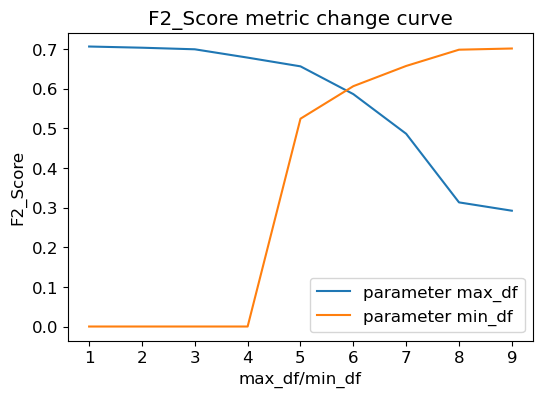

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(x, f2_Score_max_df, label='parameter max_df')
plt.plot(x, f2_Score_min_df, label='parameter min_df')
plt.xlabel('max_df/min_df')
plt.ylabel('F2_Score')
plt.title('F2_Score metric change curve')
plt.legend()
plt.show()

- Делаю вывод

Наличие высокочастотных токенов дает хороший результат в метрике

---

### NN

In [31]:
import tensorflow as tf
from keras import models
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [32]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [33]:
train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [34]:
for raw in train_data.take(1):
    pass

In [35]:
raw 

(<tf.Tensor: shape=(16,), dtype=string, numpy=
 array([b'bbc news russia lake syamozero children die storm catch boat group poorkid',
        b'go get sick face firebring open night close weekend late night show week',
        b'wait tomorrow night weekend summer',
        b'nd annual bailey day tast join us familyfun baileyday mountainliv',
        b'got addict moonblu name took life finish sold love druid wow',
        b'peopl cruel', b'redhead lovinglif tbt wednesday dodgechalleng',
        b'friday rememb judg other see love peac success',
        b'beuti poetri poetri line poetri eid new poetri tanhai poetri plz tri follow alon sana jan follow',
        b'liter bar watch end final game game lebron',
        b'hispan feel like stomp listen retweet boricua',
        b'po take paint asshol fuck chump',
        b'model love yoyou take yoyou time yoyour',
        b'sex citi paint good morn sexandthec',
        b'consult firm run small sta check us see', b'hershey bihday'],
       dtype

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
def custom_standardization(input_data):
    return input_data

vocab_size = 10000
seq_len = 50

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [38]:
model = models.Sequential()

In [39]:
model.add(vectorize_layer)
model.add(layers.Dense(64, activation='relu', input_shape=(vocab_size,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
history=model.fit(train_data, validation_data=valid_data, epochs=10, batch_size=16)

Epoch 1/10
1339/1339 [==============================] - 3s 2ms/step - loss: 12.2404 - accuracy: 0.8657 - val_loss: 4.6302 - val_accuracy: 0.8236
Epoch 2/10
1339/1339 [==============================] - 2s 2ms/step - loss: 4.3996 - accuracy: 0.8723 - val_loss: 2.8787 - val_accuracy: 0.8209
Epoch 3/10
1339/1339 [==============================] - 2s 2ms/step - loss: 2.7418 - accuracy: 0.8785 - val_loss: 2.1979 - val_accuracy: 0.7761
Epoch 4/10
1339/1339 [==============================] - 2s 2ms/step - loss: 1.7026 - accuracy: 0.8855 - val_loss: 1.1497 - val_accuracy: 0.8297
Epoch 5/10
1339/1339 [==============================] - 2s 2ms/step - loss: 1.0173 - accuracy: 0.8902 - val_loss: 0.8633 - val_accuracy: 0.8290
Epoch 6/10
1339/1339 [==============================] - 2s 2ms/step - loss: 0.6271 - accuracy: 0.9006 - val_loss: 0.4774 - val_accuracy: 0.8932
Epoch 7/10
1339/1339 [==============================] - 2s 2ms/step - loss: 0.4084 - accuracy: 0.9108 - val_loss: 0.4342 - val_accuracy

- Отображу результат обучения и валидации на графике

In [42]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

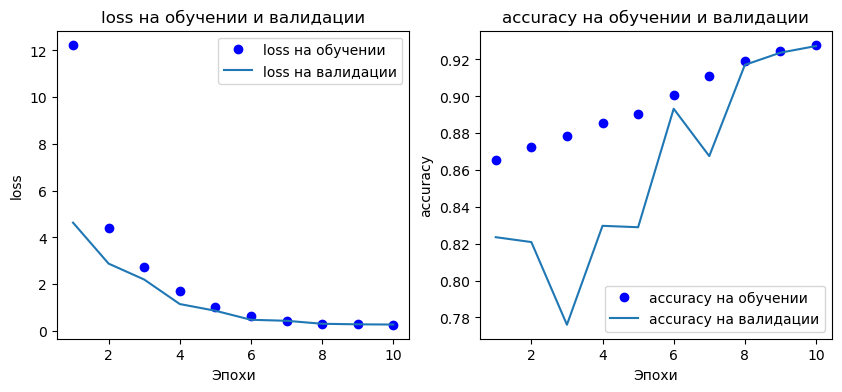

In [43]:
# построение графика loss на этапах валидации и обучения
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy'])+1)

# построение графика loss на этапах валидации и обучения
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy'])+1)

plt.figure(figsize=(10, 4))
font = {'size' : 10}
plt.rc('font', **font)

plt.subplot(121)
plt.plot(epochs, loss_values, 'bo', label = 'loss на обучении')
plt.plot(epochs, val_loss_values, label = 'loss на валидации')
plt.title('loss на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('loss')
plt.legend()

# построение графика accuracy на этапах обучения и валидации
plt.subplot(122)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label = 'accuracy на обучении')
plt.plot(epochs, val_acc_values, label = 'accuracy на валидации')
plt.title('accuracy на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#### Рассмотрю более подробно результаты работы NN.

In [44]:
pred=model.predict(valid_x)

In [45]:
from statistics import *

- распределение предикта по квантилям

In [46]:
np.percentile(pred, 15), np.percentile(pred, 95)

(0.04727241843938827, 0.13875679224729537)

- Большая часть предикта не превосходит значение 0.1.

In [47]:
xi = np.arange(1, 10000)

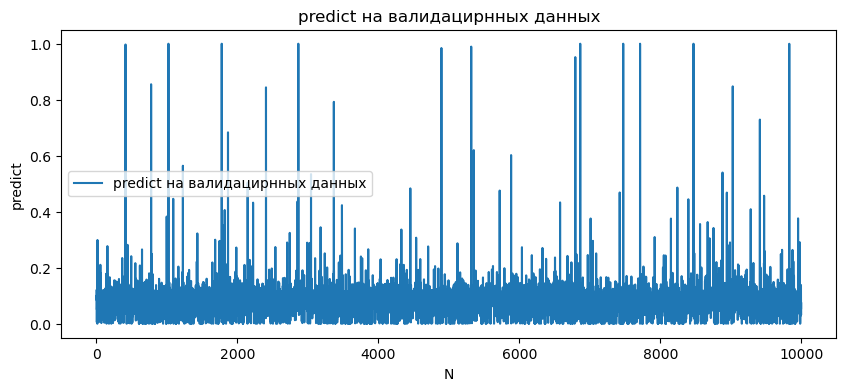

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(xi[1:10001], pred[1:9999], label = 'predict на валидацирнных данных')
plt.title('predict на валидацирнных данных')
plt.xlabel('N')
plt.ylabel('predict')
plt.legend()
plt.show()

In [49]:
# задаем порог 0,5 для классификации текста
pred1=(pred>=0.195).astype("int")
print(classification_report(valid_y, pred1))
print(confusion_matrix(valid_y,pred1))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9806
           1       0.15      0.03      0.05       742

    accuracy                           0.92     10548
   macro avg       0.54      0.51      0.50     10548
weighted avg       0.88      0.92      0.89     10548

[[9680  126]
 [ 719   23]]


 - При значениях порога выше 0.15 и ниже 0.02 значения precision обнуляется. 
 Рассмотрю диапазон изменения порога от 0.02 до 0.085 и определю на каждом значении порога значения основных метрик по целевому классу.

In [50]:
def pred_thresholds(data_y, pred):
    dict_classification_report = []
#     list_thresholds = np.linspace(0.039, 0.075, num=3601)
    list_thresholds = np.linspace(0.02, 0.2, num=1801)
    for step in list_thresholds:
        pred1=(pred>=step).astype("int")
        dict_classification_report.append(classification_report(data_y, pred1, output_dict=True))
        
    return dict_classification_report

In [51]:
dict_classification_report = pred_thresholds(valid_y, pred)

In [52]:
list_accuracy = []
list_f1score = []
list_precision = []
list_recall = []
for i, el in enumerate(dict_classification_report):
    list_accuracy.append(el['accuracy'])
    list_f1score.append(el['1']['f1-score'])
    list_precision.append(el['1']['precision'])
    list_recall.append(el['1']['recall'])

In [53]:
x = np.arange(len(list_precision))

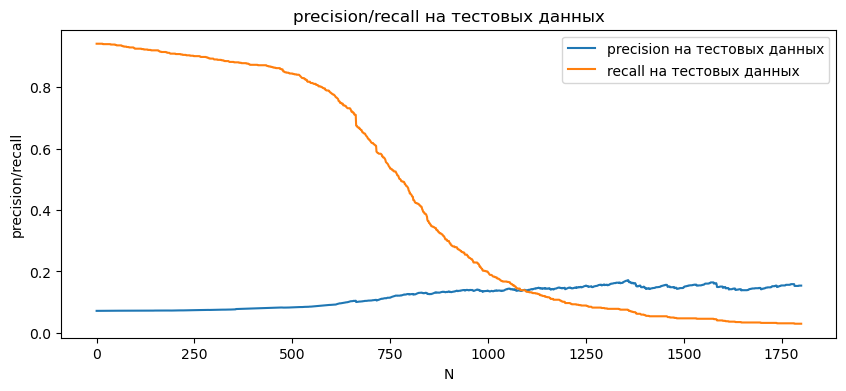

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(x, list_precision, label = 'precision на тестовых данных')
plt.plot(x, list_recall, label = 'recall на тестовых данных')
plt.title('precision/recall на тестовых данных')
plt.xlabel('N')
plt.ylabel('precision/recall')
plt.legend()
plt.show()

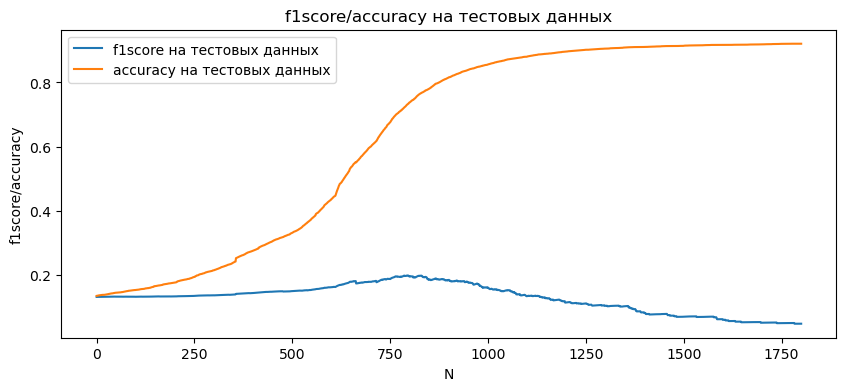

In [55]:
plt.figure(figsize=(10, 4))
plt.plot(x, list_f1score, label = 'f1score на тестовых данных')
plt.plot(x, list_accuracy, label = 'accuracy на тестовых данных')
plt.title('f1score/accuracy на тестовых данных')
plt.xlabel('N')
plt.ylabel('f1score/accuracy')
plt.legend()
plt.show()

- Из графиков видно, что нужная нам метрика F1-score не превышает значения 0.2, при этом значение accuracy устремляется к 1. Но как я указывал выше accuracy бесполезна при дисбалансе классов. Посмотрим на матрицу ошибок при высоком значении recall и высоком значении accuracy.

In [56]:
thresholds = np.linspace(0.02, 0.2, num=1801)

In [57]:
ix = 500

Confusion matrix, without normalization
[[2880 6926]
 [ 115  627]]


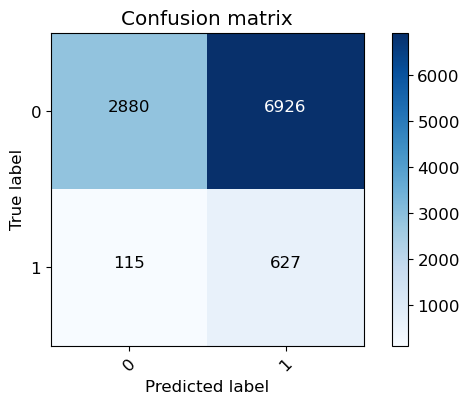

In [58]:
font = {'size' : 12}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(valid_y, pred > thresholds[ix])
plt.figure(figsize=(6, 4))
mcm.plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [59]:
ix = 800

Confusion matrix, without normalization
[[7447 2359]
 [ 405  337]]


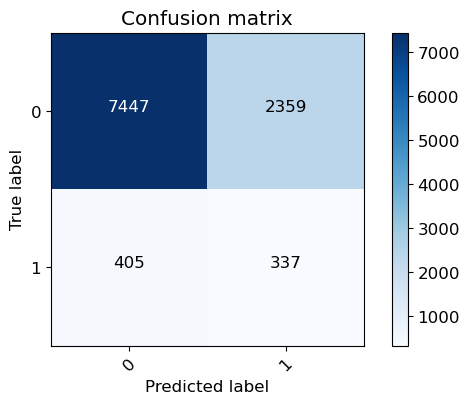

In [60]:
font = {'size' : 12}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(valid_y, pred > thresholds[ix])
plt.figure(figsize=(6, 4))
mcm.plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

---

In [61]:
ix = 1750

Confusion matrix, without normalization
[[9680  126]
 [ 719   23]]


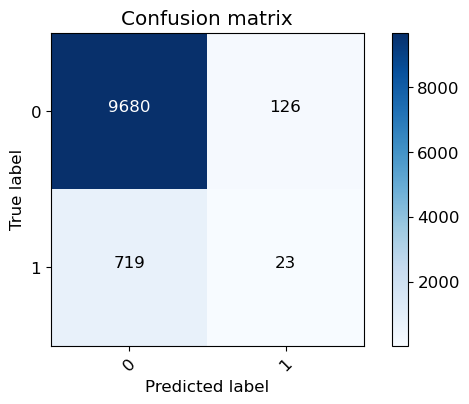

In [63]:
font = {'size' : 12}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(valid_y, pred > thresholds[ix])
plt.figure(figsize=(6, 4))
mcm.plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [64]:
TP = 23
TN = 9680
FP = 126
FN = 719
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Accuracy

0.9198900265453166

- Метрика Accuracy высокая, но при сильном дисбалансе классов результат откровенно плохой в поиске целевого класса.

### Вывод: На данном этапе LogisticRegression на любом из Vectorizer дает лучшие результаты.